# Adding CO lines to PySM 


Planck released  maps for the first CO rotational  lines, i.e. $J =1-0, 2-1, 3-2$, whose center frequency is respectively at : $\nu _0 = 115.271, 230.538, 345.796$ GHz. The maps we use are therefore  extracted from $100, 217 , 353 $ GHz  HFI channels.  
Several type of CO maps have been  obtained with different  component separation algorithms. We 've chosen the ones with the largest signal-to-noise ratio,  the  [Type 1 CO maps](http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=HFI_CompMap_CO-Type1_2048_R2.00.fits) as described in Planck XIII (2014). Those maps have been estimated with ` MILCA ` algorithm and they exploit the differences in  bands within each  frequency channel, this also allowed them to extract CO line maps at the nominal resolution of a given HFI channel. 



Planck released maps 

### CO Maps Pre-processing  
   1. Maps `HFI_CompMap_CO-Type1_2048_R2.00.fits` come together with a point source mask , we set the mask pixels to zero
   2.  Maps are realeased in the units of $K (km /s) $,  we converted them into $K_{CMB}$ by multplying  the measured spectral bandpass  of the detectors $F_{CO}$ (as explained in Planck  Collaboration IX (2014) and Planck Collaboration XIII (2014) )  : 

    - CO 1-0 : $1.42 \times 10 ^{-5} K_{CMB}/ K  (km s^{-1})$
    - CO 2-1 : $4.50\times 10 ^{-5} K_{CMB}/ K  (km s^{-1})$
    - CO 3-2 : $17.37 \times 10 ^{-5} K_{CMB}/ K  (km s^{-1})$
   3. To reduce noise content at High Galactic latitudes we convolved maps with a 1 deg beam. 
   4. Maps  have been downgraded from `nside=2048`  to  `nside=512` to avoid memory issues . 


Below string code we've run for  preprocessing

```
m = hp.read_map('CO_data/HFI_CompMap_CO-Type1_2048_R2.00.fits', field=range(12)[::4], verbose=False)
mask = hp.read_map('CO_data/HFI_CompMap_CO-Type1_2048_R2.00.fits', field=range(12)[3::4], verbose=False)
m2= [  m[0] *mask[0], m[1] *mask[1], m[2]*mask[2]  ]
mask2= [ pl.ma.masked_not_equal(i ,hp.UNSEEN).mask  for i in (m2)  ]
fCO= {'1-0': 1.42e-5, '2-1':4.5e-5, '3-2':17.37e-5}
co10K = ( fCO ['1-0'] ) * m2[0] *pl.int0 ( mask2[0])
co21K = (fCO ['2-1'] ) *m2[1] *pl.int0 (mask2[1] )
co32K = ( fCO ['3-2'] ) *m2[2]*pl.int0 (mask2[2] )
co10Ks=hp.smoothing(co10K , fwhm =pl.deg2rad(1.), lmax=1024, pol=False)
co21Ks=hp.smoothing(co21K , fwhm =pl.deg2rad(1.) , lmax=1024, pol=False)
co32Ks=hp.smoothing(co32K , fwhm =pl.deg2rad(1.) , lmax=1024, pol=False)
```

In [1]:
import pylab as pl 
from  numpy.random import normal 
import numpy as np
import healpy as hp 
from pylab import cm 
cmap = cm.get_cmap('RdYlBu')
cmap.set_under('w')

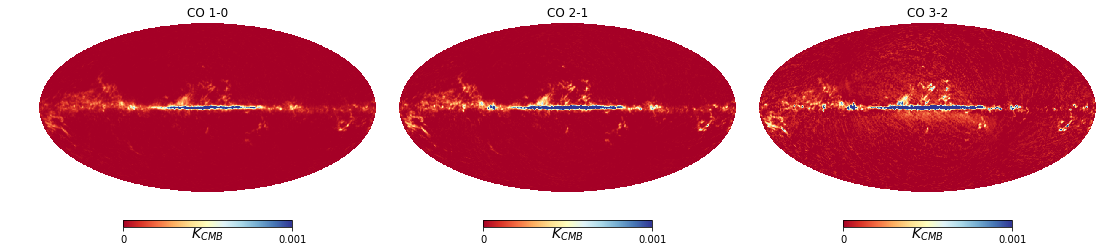

In [7]:
co10K= hp.read_map('data/Planck_maps/HFI_CompMap_CO-Type1_512_R2.00_ring.fits', verbose=False)
co21K= hp.read_map('data/Planck_maps/HFI_CompMap_CO-Type1_512_R2.00_ring.fits', field=1, verbose=False)
co32K= hp.read_map('data/Planck_maps/HFI_CompMap_CO-Type1_512_R2.00_ring.fits', field=2, verbose=False)
fig=pl.figure(figsize=(15,8))
hp.mollview(co10K, cmap=cmap, min = 0, max=1e-3, sub=131, title='CO 1-0', unit=r'$K_{CMB}$' )
hp.mollview(co32K, cmap=cmap, min = 0, max=1e-3, sub=133, title='CO 3-2', unit=r'$K_{CMB}$' )
hp.mollview(co21K, cmap=cmap, min=0., max=1e-3, sub=132, title='CO 2-1' , unit=r'$K_{CMB}$')

## Implementation 

Below you can find a prototype class I 've developed to be included in PySM. 
I follow the constructor from AME and Synchrotron classes to be consistent  to the current PySM implementation.  

All the maps needed to perform those sims are in a folder of my CoriScratch made accessible to mp107 group. 
``/global/cscratch1/sd/giuspugl/CO_data`` 


Another requirement is also now to import the package I and Giulio Fabbian developed to simulate molecular clouds :
you need to  clone  https://github.com/giuspugl/MCMole3D.git 


In [39]:
import cloudmodel as cl  


class CO(object) : 
    def __init__(self,
                 target_nside ,
                 has_polarization=True,
                 line='10',
                 include_highGalLat_clouds=False, 
                 Pol_Frac =0.001 ,
                 theta_HGL = 0., verbose=False ): 
        
        """Class defining attributes for CO line emission.
           CO templates are extracted from Type 1 CO Planck maps. 
           See further details in https://www.aanda.org/articles/aa/abs/2014/11/aa21553-13/aa21553-13.html

        Parameters
        ----------
        target_nside : int
            HEALPix NSIDE of the output maps
        has_polarization : bool
            whether or not to simulate also polarization maps
            Default: True
        line : string 
            CO rotational transitions. 
            Accepted values : 10, 21, 32  
            Default: 10 
        Pol_Frac: float
            polarisation fraction for polarised CO emission.
            Default: 0.001 
        include_highGalLat_clouds: bool 
            If True it performs a simulation with MCMole3D which can include 
            high Galactic Latitude clouds. Default: False 
            (See more details at http://giuspugl.github.io/mcmole/index.html) 
        theta_HGL: float
            Angle in degree  to identify High Galactic Latitude clouds 
            (i.e. clouds whose latitude b is |b|> theta_HGL). 
            Default: 0 
        """
        
        self._line =line 
        dic_lines={'10':0, '21':1, '32':2 }
        
        self.target_nside=target_nside 
        
        if self.target_nside <= 512 :
            self.planck_templatemap= hp.read_map('data/Planck_maps/HFI_CompMap_CO-Type1_512_R2.00_ring.fits'  ,
                                         field=dic_lines[self._line], verbose=False)
        else : 
            self.planck_templatemap= hp.read_map('data/Planck_maps/HFI_CompMap_CO-Type1_2048_R2.00_ring.fits'  ,
                                         field=dic_lines[self._line], verbose=False)
            
        self.HGL=include_highGalLat_clouds 
        self.has_polarization=has_polarization
        self.Pol_Frac =Pol_Frac 
        self.theta_HGL=theta_HGL 
        self.verbose=verbose 
        
    def signal(self): 
        """
        Simulate CO signal 
        """
        out= np.zeros( hp.nside2npix(self.target_nside )*3 ).reshape(3,hp.nside2npix(self.target_nside ) ) 
        out[0] = hp.ud_grade( map_in= self.planck_templatemap , nside_out=self.target_nside  )
        if self.HGL : 
            self.simulated_HGLemission =self.simulate_HighGalacticLatitude_CO() 
            out[0]+=  self.simulated_HGLemission  
            
        if self.has_polarization:
            self.add_polarization(out )
            return out
        else: 
            return   out[0]
            
    def add_polarization(self, Imap ):
        """
        Add polarized emission by means of:
        - an overall constant polarization fraction, 
        - a depolarization map to mimick the line of sight depolarization 
          effect at low Galactic latitudes 
        - a polarization angle map coming from a dust template 
          (we exploit the observed correlation between polarized dust and 
          molecular emission in star forming regions). 
        """
        if self.target_nside<=512 : 
            polangle = hp.read_map( './data/auxiliary_data/psimap_dust90_10arcmin_512.fits', verbose=False)
            depolmap = hp.read_map('./data/auxiliary_data/gmap_dust90_10arcmin_512.fits', verbose=False ) 
            
        else :
            polangle = hp.read_map( './data/auxiliary_data/psimap_dust90_3.5arcmin_2048.fits', verbose=False)
            depolmap = hp.read_map('./data/auxiliary_data/gmap_dust90_3.5arcmin_2048.fits', verbose=False )
        
        if hp.get_nside(depolmap)!= self.target_nside:
            polangle = hp.ud_grade( map_in= polangle , nside_out=self.target_nside  )
            depolmap = hp.ud_grade( map_in= depolmap , nside_out=self.target_nside  )
        
        cospolangle =np.cos(2.*polangle) 
        sinpolangle =np.sin(2.*polangle)
       
        Imap[1]  = self.Pol_Frac  *depolmap *cospolangle *Imap[0]
        Imap[2]  = self.Pol_Frac  *depolmap *sinpolangle *Imap[0]
        
        
    def simulate_HighGalacticLatitude_CO ( self ):
        """
        Simulate High Galactic Latitude CO emission, by means of MCMole3D package 
        
        """
        
        #params to MCMole 
        N=40000
        L_0=20.4 #pc 
        L_min=.3 
        L_max=60.
        R_ring =5.8
        sigma_ring =2.7 #kpc
        R_bulge = 3.
        R_z=10 #kpc 
        z_0=0.1 
        Em_0 = 240. 
        R_em = 6.6
        model= 'LogSpiral'

        nside=self.target_nside
        Itot_o, _ =cl.integrate_intensity_map(self.planck_templatemap,hp.get_nside(self.planck_templatemap) ,planck_map=True)
        Pop=cl.Cloud_Population(N, model, randseed= np.random.randint(low=0, high=1e6 ))
        
        Pop.set_parameters(radial_distr=[ R_ring,sigma_ring ,R_bulge],
                               typical_size=L_0,
                               size_range=[L_min,L_max],
                               thickness_distr=[z_0, R_z] ,
                               emissivity=[Em_0,R_em])
        Pop()
        
        if self.verbose: Pop.print_parameters() 
        #project into  Healpix maps
        mapclouds       = cl.do_healpy_map(Pop, nside, highgalcut=np.deg2rad( 90. - self.theta_HGL ),
                                           apodization='gaussian', verbose=self.verbose )
        Itot_m, _       = cl.integrate_intensity_map(mapclouds, nside)
        #convert simulated map into the units of the Planck one 
        rescaling_factor= Itot_m/Itot_o
        mapclouds      /= rescaling_factor
        hglmask =np.zeros_like(mapclouds)
        #Apply mask to low galactic latitudes 
        listhgl=hp.query_strip(nside , pl.deg2rad(90. +self.theta_HGL ), pl.deg2rad(90 - self.theta_HGL))
        hglmask[listhgl]=1.        
        rmsplanck=self.planck_templatemap[listhgl].std() 
        rmssim = mapclouds[listhgl].std()
        if rmssim ==0.: 
            belowplanck=1.
        else:
            #belowplanck=1. 
            belowplanck =rmssim/rmsplanck
            
        return mapclouds* hglmask/belowplanck 


## Simulating Intensity and Polarization CO maps

Intrinsic polarization from CO molecular emission is expected to a certain extent ( Goldreich effect, Goldreich 1981) and  has been detected locally in several molecular complex such as Orion and Taurus, to the level of $3 \% $ (Greaves et al. 1999 ). 

If `has_polarization= True`,  the PySM  simulates polarized emission   in each pixel  assuming a constant fractional polarization  $f_{pol} =0.1$ % and the planck CO emission map , $I_{CO}$. We thus  estimate $Q$ and $U$ maps as : 
$$
Q = f_{pol} I_{CO}  g_d \cos( 2 \psi) 
$$
$$
U  = f_{pol} I_{CO}  g_d \sin( 2 \psi) 
$$

with $g_d $ and $\psi$ being respectively the _depolarization_ and _polarization angle_ maps estimated from a dust map as : 
$$ 
g_d = \frac{ \sqrt{Q_{d,353}  ^2   + U_{d,353}  ^2 } }{f_{pol} I_{d,353} } 
$$
 
$$ 
\psi = \frac{1}{2} \arctan {\frac{U_{d,353}}{Q_{d,353}}}
$$


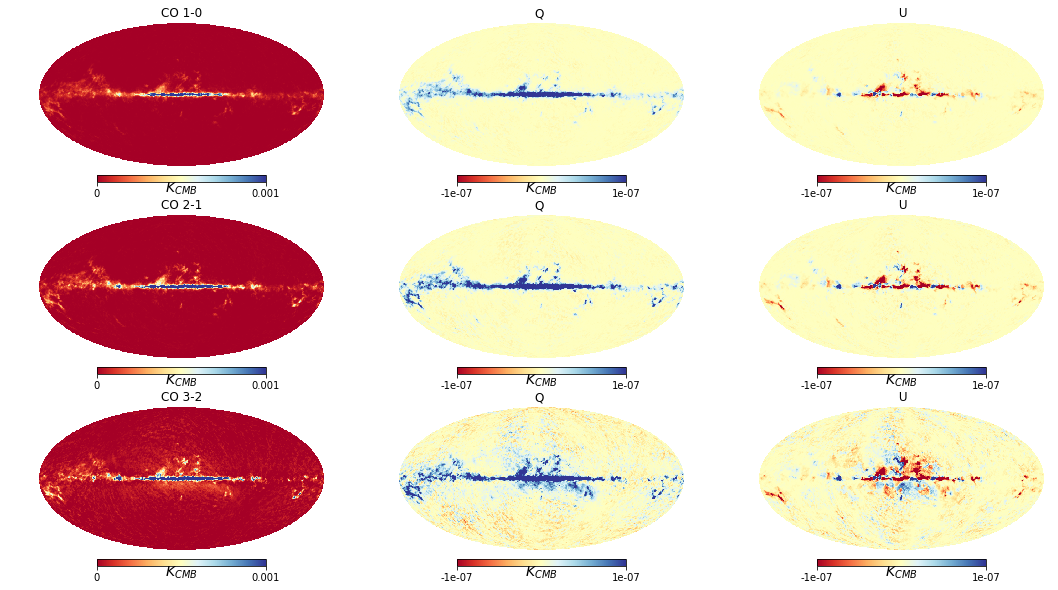

In [112]:
COmodel10 = CO(line='10', include_highGalLat_clouds=False,target_nside=64, has_polarization=True)
co10sim = COmodel10.signal()
COmodel21 = CO(line='21', include_highGalLat_clouds=False,target_nside=64, has_polarization=True)
co21sim = COmodel21.signal()
COmodel32 = CO(line='32', include_highGalLat_clouds=False,target_nside=64, has_polarization=True)
co32sim = COmodel32.signal()


fig=pl.figure(figsize=(15,8))
hp.mollview(co10sim[0], cmap=cmap, min = 0, max=1e-3, sub=331, title='CO 1-0', unit=r'$K_{CMB}$' )
hp.mollview(co10sim[1], cmap=cmap, min=-1e-7, max=1e-7, sub=332, title='Q ', unit=r'$K_{CMB}$' )
hp.mollview(co10sim[2], cmap=cmap, min =-1e-7, max=1e-7, sub=333, title=' U' , unit=r'$K_{CMB}$')

hp.mollview(co21sim[0], cmap=cmap, min = 0, max=1e-3, sub=334, title='CO 2-1' , unit=r'$K_{CMB}$')
hp.mollview(co21sim[1], cmap=cmap, min=-1e-7, max=1e-7, sub=335, title='Q ' , unit=r'$K_{CMB}$')
hp.mollview(co21sim[2], cmap=cmap, min =-1e-7, max=1e-7, sub=336, title=' U' , unit=r'$K_{CMB}$')

hp.mollview(co32sim[0], cmap=cmap, min = 0, max=1e-3, sub=337, title='CO 3-2' , unit=r'$K_{CMB}$')
hp.mollview(co32sim[1], cmap=cmap, min=-1e-7, max=1e-7, sub=338, title='Q ' , unit=r'$K_{CMB}$')
hp.mollview(co32sim[2], cmap=cmap, min =-1e-7, max=1e-7, sub=339, title=' U' , unit=r'$K_{CMB}$')


## Including High Galactic Latitudes clouds 

As shown in the pnale above,    there are still   regions at high Galactic latitudes (HGL)   where the CO emission has   been purely  assessed   and where the Planck signal-to-noise was not enough to detect any HGL emission.  



The MCMole input parameters  (so far hard coded )  are the ones that are obtained from  best fit with  the  Planck CO 1-0 map (see Puglisi et al. 2017 ). If `include_highGalLat_clouds=True`, a mock CO cloud map is simulated with MCMole3D and coadded  to the Planck CO emission map. The polarization is simulated similarly as above.   

We give the PySM user the possibility to include  the eventuality of molecular emission (both unpolarized and polarized) at HGL. The parameter `theta_HGL`   sets the latitude  threshold  and can be defined  in the constructor.  

Let's see a couple of   realizations of HGL clouds.


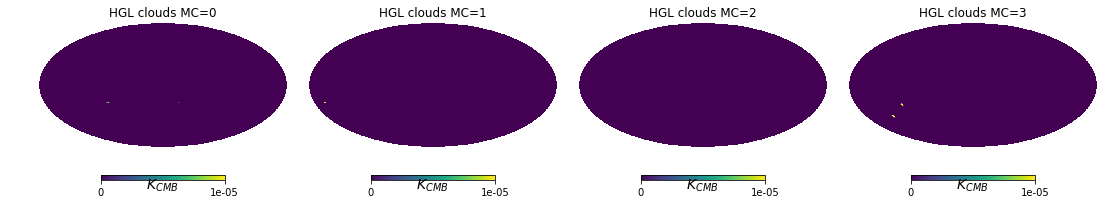

In [40]:
fig=pl.figure(figsize=(15,8))
for i in range(4):
    COmodelh10 = CO(line='10', include_highGalLat_clouds=True,target_nside=64, has_polarization=False, theta_HGL= 20.,
                verbose=False)
    co10sim = COmodelh10.signal()
    hp.mollview(COmodelh10.simulated_HGLemission,sub = 141+i,   min = 0, max=1e-5  , 
              title='HGL clouds MC={}'.format(i) , unit=r'$K_{CMB}$')


**Caption:** As  expected  few clouds at HGL are simulated and they look as point sources (the angular size is expected to be up to the degree scale. We also made sure that the flux of HGL clouds to be lower than the Planck sensitivity at those latitudes, otherwise they would have been detected in Planck observations. 


Finally, let's simulate for the 3 CO lines 

############################################################
Parameters  to MCMole3D
------------------------------------------------------------
Model				....	 LogSpiral
#clouds				....	 40000
Molecular Ring [location,width]	....	 5.8,2.29317	 kpc
Central Midplane Thickness	....	 42.4661	 pc
Radius of the Galactic Bar 	....	 3	 kpc
Scale Radius Midplane Thickness	....	 10	 kpc
Amplitude Emissivity profile	....	 240	 K km/s
Scale Radius Emissivity profile	....	 6.6	 kpc
Cloud Typical size		....	 20.4	 pc
Cloud size [min,max]		....	 0.3,60	 pc
############################################################
Excluded 1 clouds at high galactic latitude. (|b|>20)



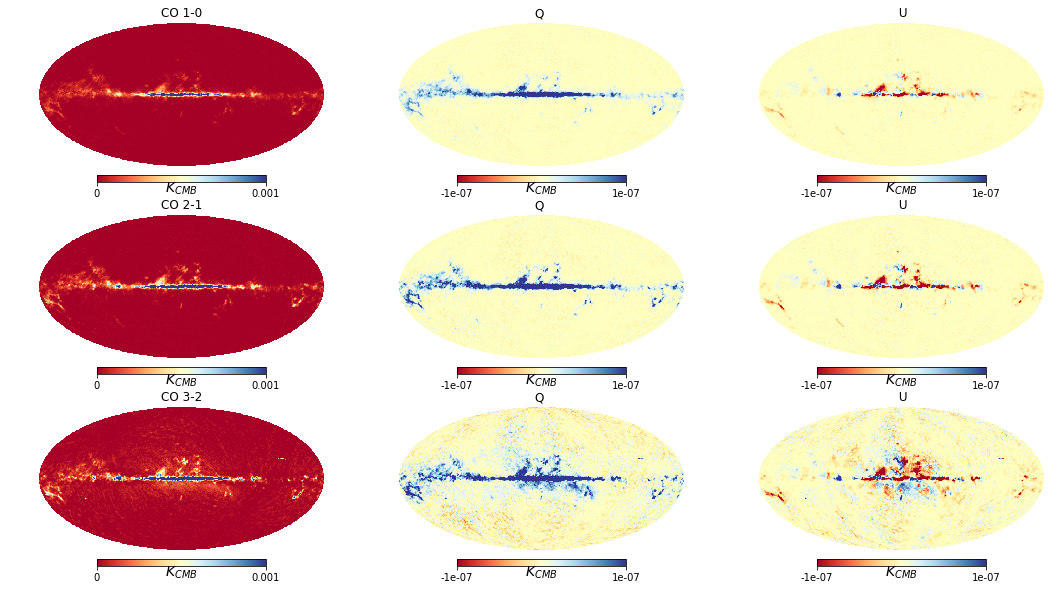

In [41]:
COmodelh10 = CO(line='10', include_highGalLat_clouds=True,target_nside=64, has_polarization=True, theta_HGL= 20.,
                verbose=True)
co10sim = COmodelh10.signal() 
COmodelh21 = CO(line='21', include_highGalLat_clouds=True,target_nside=64, has_polarization=True, theta_HGL=20.)
co21sim = COmodelh21.signal()
COmodelh32 = CO(line='32', include_highGalLat_clouds=True,target_nside=64, has_polarization=True, theta_HGL=20.)
co32sim = COmodelh32.signal()


fig=pl.figure(figsize=(15,8))
hp.mollview(co10sim[0], cmap=cmap, min = 0, max=1e-3 ,sub=331 , title='CO 1-0',  unit=r'$K_{CMB}$' )
hp.mollview(co10sim[1], cmap=cmap, min=-1e-7, max=1e-7, sub=332, title='Q ', unit=r'$K_{CMB}$' )
hp.mollview(co10sim[2], cmap=cmap, min =-1e-7, max=1e-7, sub=333, title=' U' , unit=r'$K_{CMB}$')
hp.mollview(co21sim[0], cmap=cmap, min = 0, max=1e-3, sub=334, title='CO 2-1' , unit=r'$K_{CMB}$')
hp.mollview(co21sim[1], cmap=cmap, min=-1e-7, max=1e-7, sub=335, title='Q ' , unit=r'$K_{CMB}$')
hp.mollview(co21sim[2], cmap=cmap, min =-1e-7, max=1e-7, sub=336, title=' U' , unit=r'$K_{CMB}$')
hp.mollview(co32sim[0], cmap=cmap, min = 0, max=1e-3, sub=337, title='CO 3-2' , unit=r'$K_{CMB}$')
hp.mollview(co32sim[1], cmap=cmap, min=-1e-7, max=1e-7, sub=(338), title='Q ' , unit=r'$K_{CMB}$')
hp.mollview(co32sim[2], cmap=cmap, min =-1e-7, max=1e-7, sub=339, title=' U' , unit=r'$K_{CMB}$')
